In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
import os
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch
from torchvision import datasets, transforms

def prepare_data_loaders(training_batch_size, evaluation_batch_size):

    image_transforms = transforms.Compose([
        transforms.Resize((32, 32)),  
        transforms.ToTensor()         
    ])
    
    
    mnist_training_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data_mnist', train=True, download=True,
                       transform=image_transforms),
        batch_size=training_batch_size, shuffle=True)
    
    
    mnist_evaluation_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data_mnist', train=False,
                       transform=image_transforms),
        batch_size=evaluation_batch_size, shuffle=False)  

    return mnist_training_loader, mnist_evaluation_loader


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv_layer2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.dense_layer1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.dense_layer2 = nn.Linear(in_features=120, out_features=84)
        self.output_layer = nn.Linear(in_features=84, out_features=10)

    def forward(self, input_tensor):
        input_tensor = F.max_pool2d(F.relu(self.conv_layer1(input_tensor)), kernel_size=2)
        input_tensor = F.max_pool2d(F.relu(self.conv_layer2(input_tensor)), kernel_size=2)
        input_tensor = input_tensor.view(-1, 16 * 5 * 5)
        input_tensor = F.relu(self.dense_layer1(input_tensor))
        input_tensor = F.relu(self.dense_layer2(input_tensor))
        input_tensor = self.output_layer(input_tensor)
        return input_tensor


In [5]:
def configure_optimizer(network):
    learning_rate = 0.01  
    momentum_coefficient = 0.9
    use_nesterov = True


    sgd_optimizer = optim.SGD(
        network.parameters(), 
        lr=learning_rate, 
        momentum=momentum_coefficient, 
        nesterov=use_nesterov
    )

    return sgd_optimizer

def sensitivity(model):
    total_norm = 0.0
    parameters_with_gradients = 0
    
    for parameter in model.parameters():
        if parameter.grad is not None:
            parameter_norm = parameter.grad.data.norm(2)  
            total_norm += parameter_norm.item()  
            parameters_with_gradients += 1
    
    average_norm = total_norm / parameters_with_gradients if parameters_with_gradients > 0 else 0
    return average_norm


In [6]:
def train_network(network, sgd_optimizer, mnist_training_loader):
    network.train()  
    criterion = CrossEntropyLoss()  
    
    for batch_index, (inputs, labels) in enumerate(mnist_training_loader):
        inputs, labels = Variable(inputs), Variable(labels)
        sgd_optimizer.zero_grad()  

        predictions = network(inputs)
        training_loss = criterion(predictions, labels)  
        training_loss.backward() 
        sgd_optimizer.step()  

def evaluate_performance(network, dataset_loader, criterion):
    total_correct = 0
    total_samples = 0
    accumulated_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch_data in dataset_loader:
            inputs, targets = batch_data
            predictions = network(inputs)
            loss = criterion(predictions, targets)
            accumulated_loss += loss.item()  
            batch_count += 1
            total_correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            total_samples += targets.size(0)
    
    average_loss = accumulated_loss / batch_count
    accuracy = total_correct / total_samples
    
    return average_loss, round(accuracy, 3)

In [7]:
epochs = 30
def execute_training_and_evaluation(network_model, sgd_optimizer, training_loader, testing_loader, loss_criterion):
    losses_training = []
    losses_validation = []
    accuracy_training = []
    accuracy_validation = []

    for current_epoch in range(1, epochs + 1):
        train_network(network_model, sgd_optimizer, training_loader)

        loss_training, acc_training = evaluate_performance(network_model, training_loader, loss_criterion)

        loss_validation, acc_validation = evaluate_performance(network_model, testing_loader, loss_criterion)

        print(f"Epoch {current_epoch} - Training Loss: {loss_training:.4f}, Validation Loss: {loss_validation:.4f}, Training Acc: {acc_training:.2f}, Validation Acc: {acc_validation:.2f}")

        # Append results for plotting or analysis
        losses_training.append(loss_training)
        losses_validation.append(loss_validation)
        accuracy_training.append(acc_training)
        accuracy_validation.append(acc_validation)

    return losses_training, losses_validation, accuracy_training, accuracy_validation


Epoch 1 - Training Loss: 0.1145, Validation Loss: 0.1011, Training Acc: 0.96, Validation Acc: 0.97
Epoch 2 - Training Loss: 0.0695, Validation Loss: 0.0676, Training Acc: 0.98, Validation Acc: 0.98
Epoch 3 - Training Loss: 0.0522, Validation Loss: 0.0553, Training Acc: 0.98, Validation Acc: 0.98
Epoch 4 - Training Loss: 0.0404, Validation Loss: 0.0464, Training Acc: 0.99, Validation Acc: 0.98
Epoch 5 - Training Loss: 0.0384, Validation Loss: 0.0437, Training Acc: 0.99, Validation Acc: 0.99
Epoch 6 - Training Loss: 0.0270, Validation Loss: 0.0393, Training Acc: 0.99, Validation Acc: 0.99
Epoch 7 - Training Loss: 0.0246, Validation Loss: 0.0331, Training Acc: 0.99, Validation Acc: 0.99
Epoch 8 - Training Loss: 0.0223, Validation Loss: 0.0338, Training Acc: 0.99, Validation Acc: 0.99
Epoch 9 - Training Loss: 0.0182, Validation Loss: 0.0382, Training Acc: 0.99, Validation Acc: 0.99
Epoch 10 - Training Loss: 0.0159, Validation Loss: 0.0368, Training Acc: 0.99, Validation Acc: 0.99
Epoch 1 -

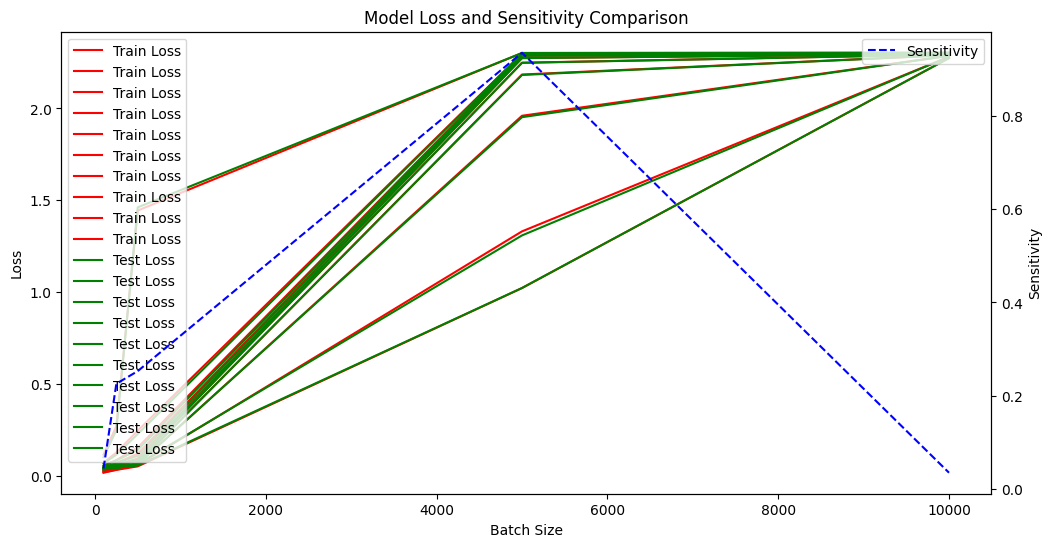

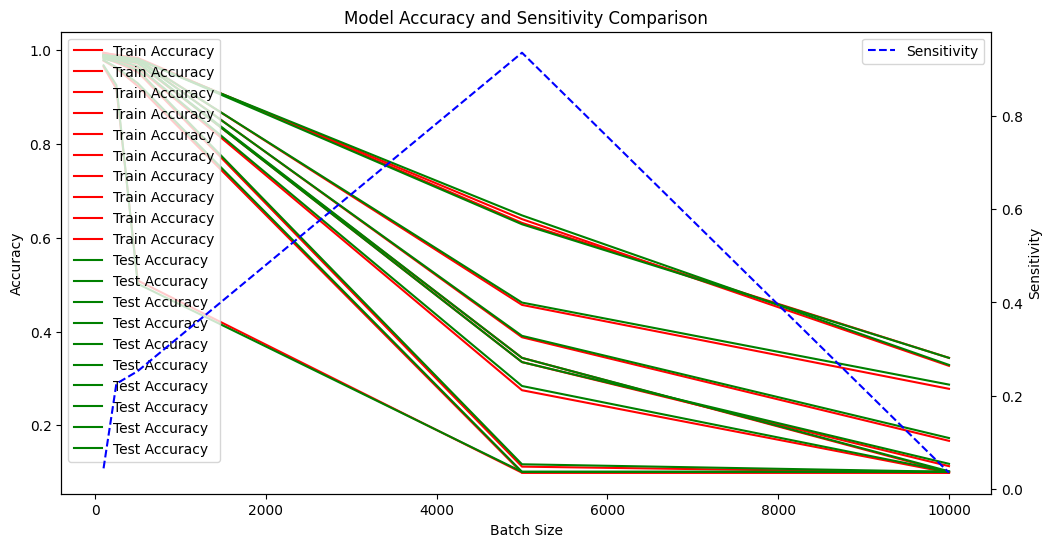

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming the CustomCNN class is defined as CNN and functions load_data, define_optimizer, compute, and sensitivity are correctly defined

epochs = 10
batch_size = [100, 250, 500, 5000, 10000]

# Initialize arrays to store metrics
loss_train_arr = []
loss_test_arr = []
train_acc_arr = []
test_acc_arr = []
sensList = []

for batch in batch_size:
    torch.manual_seed(1)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, test_loader = prepare_data_loaders(batch, batch)  # Use the correct data loading function
    model = CustomCNN()  # Assuming CNN is defined as CustomCNN
    optimizer = configure_optimizer(model)  # Ensure this function is defined to configure the optimizer
    
    # Compute function needs to correctly train the model and return metrics; assuming it's modified to do so
    train_loss, test_loss, train_acc, test_acc = execute_training_and_evaluation(model, optimizer, train_loader, test_loader, criterion)
    
    # Store the computed metrics
    loss_train_arr.append(train_loss)
    loss_test_arr.append(test_loss)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
    
    # Append sensitivity of the model after training
    sensList.append(sensitivity(model))

# Convert collected lists to a clean format if necessary; here assumed direct plotting is possible

# Plotting the loss comparison
plt.figure(figsize=(12,6))
plt.plot(batch_size, loss_train_arr, 'r-', label='Train Loss')
plt.plot(batch_size, loss_test_arr, 'g-', label='Test Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Plot sensitivity on the same graph
plt.twinx()
plt.plot(batch_size, sensList, 'b--', label='Sensitivity')
plt.ylabel('Sensitivity')
plt.title('Model Loss and Sensitivity Comparison')
plt.legend(loc='upper right')
plt.show()

# Plotting the accuracy comparison
plt.figure(figsize=(12,6))
plt.plot(batch_size, train_acc_arr, 'r-', label='Train Accuracy')
plt.plot(batch_size, test_acc_arr, 'g-', label='Test Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot sensitivity on the same graph
plt.twinx()
plt.plot(batch_size, sensList, 'b--', label='Sensitivity')
plt.ylabel('Sensitivity')
plt.title('Model Accuracy and Sensitivity Comparison')
plt.legend(loc='upper right')
plt.show()
